# Goals
- Prove that learning is problematic for networks with high batch size or high learning rate
- Understand / Implement LARS optimizer
- Compare LARS vs no LARS optimizer in tinyImagenet or Imagenet for high batch size

## References
- [LARS paper](https://arxiv.org/pdf/1708.03888v3)

In [1]:
import torch.nn as nn
import torch
from torchvision import models
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from utils import get_tinyimagenet_data, fit_profile

/home/ajrfhp/anaconda3/envs/GPT2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, val_loader = get_tinyimagenet_data(batch_size=256, num_workers=0)
model = models.resnet18(pretrained=False)
model.to(device)
summary(model, (3, 224, 224))


/home/ajrfhp/anaconda3/envs/GPT2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ajrfhp/anaconda3/envs/GPT2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Training batch 0
Training batch 1
Validation batch 0
Validation batch 1
epoch: 0, val_loss: 0.34274308681488036, val_acc: 0.025


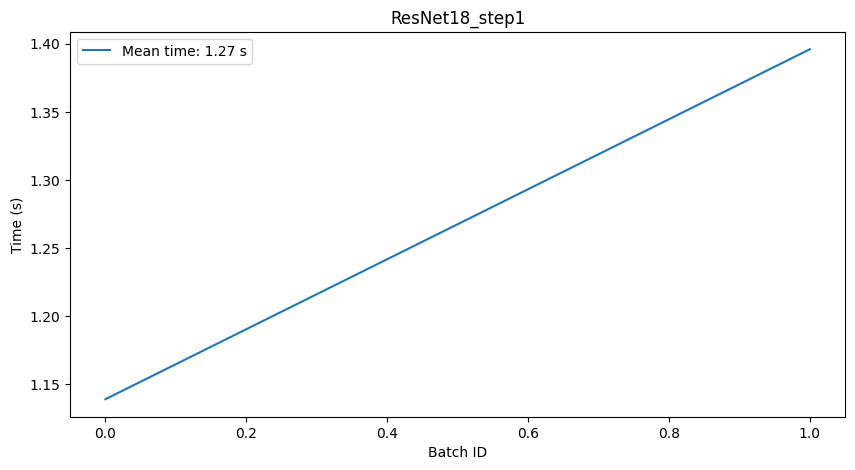

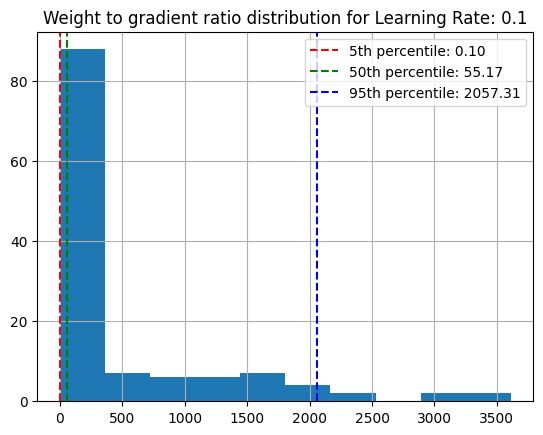

/home/ajrfhp/anaconda3/envs/GPT2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ajrfhp/anaconda3/envs/GPT2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training batch 0
Training batch 1
Validation batch 0
Validation batch 1
epoch: 0, val_loss: nan, val_acc: 0.1


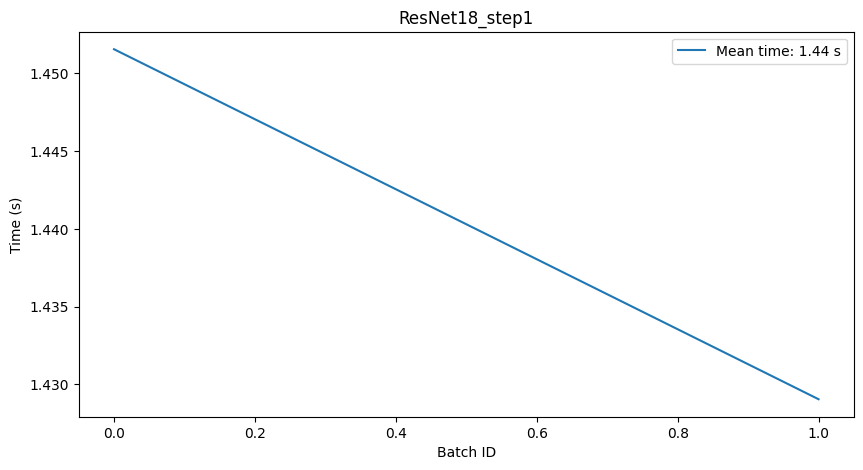

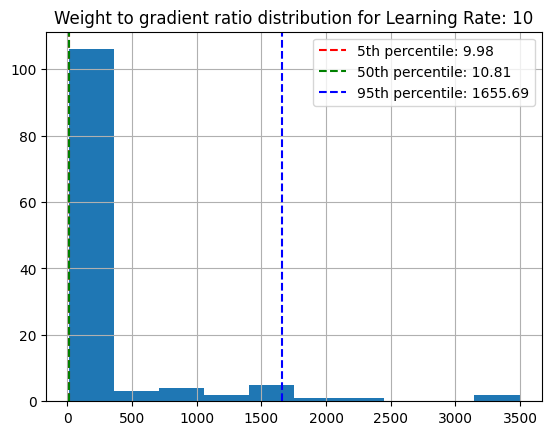

In [3]:


for lr in [0.1, 10]:
    model = models.resnet18(pretrained=False)
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    gradient_ratio_dataframe = fit_profile(model, train_loader, val_loader, device=device, epochs=1, lr=lr, num_steps=1, title="ResNet18_step1", print_gradient_ratio=True, optimizer=optimizer)

    gradient_ratio_dataframe['ratio'].hist()
    p05 = gradient_ratio_dataframe['ratio'].quantile(0.05)
    p50 = gradient_ratio_dataframe['ratio'].quantile(0.5)
    p95 = gradient_ratio_dataframe['ratio'].quantile(0.95)
    plt.axvline(p05, color='r', linestyle='--', label=f'5th percentile: {p05:.2f}')
    plt.axvline(p50, color='g', linestyle='--', label=f'50th percentile: {p50:.2f}')
    plt.axvline(p95, color='b', linestyle='--', label=f'95th percentile: {p95:.2f}')
    plt.title(f"Weight to gradient ratio distribution for Learning Rate: {lr}")
    plt.legend()
    plt.show()